In [151]:
import pickle
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [152]:
def change_features(df):
    df['AVG_returns'] = (df['AVG_returns'] + 1) ** 252 - 1
    df['Risk'] = (df['Risk'] + 1) ** np.sqrt(252) - 1
    df['Alpha'] = df['Alpha'].round(4)
    df['Drawdown'] = -df['Drawdown']
    return df 

In [153]:
dict_category2emb = {
    'topological features' : [
        'PersImage_2',
        'PersLandscape_1',
        'PersImage_1',
        'PersLandscape_2',
        'topo_features',
        'PersImage_2_new',
        'PersLandscape_1_new',
        'PersImage_1_new',
        'PersLandscape_2_new',
        'topo_features_new',                      
      ],
    
    'Dimensionality reduction' : ['umap', 'pca', 'fastica', 'tnse'],
    
    'transformers' : [ 
        'transformer_embds1',
        'transformer_embds2',
        'transformer_embds3',
        'transformer_embds_sum_23',
        'transformer_embds_sum_all',
    ],
    
    'autoencoders' : [ 
        'autoencoder_conv',
        'autoencoder_lstm',
        'autoencoder_mlp',
    ],
    
    #'baselines' : ['sp500', 'sectors'],
    'index': ['sp500'],
    'ecomonic sectors': ['sectors'],
    
    'classical features' : [ 'tsfresh', 'table_finance_features'],
    
#     'time_clustering' : ['KShape',
#  'MSTcorr',
#  'TimeSeriesKMeans'],
    
    'time series embedding' : ['ts2vec', 'signal2vec_embds']
}

dict_emb2cat = {method:categ for categ, list_methods in dict_category2emb.items() for method in list_methods }

# Data loading

In [154]:
fin_results_2012 = pd.read_csv('results/usa_2012_s2v/financial_metric_False.csv', index_col=0)
fin_results_2015 = pd.read_csv('results/usa_2015_s2v/financial_metric_False.csv', index_col=0)
fin_results_2018 = pd.read_csv('results/usa_2018_s2v/financial_metric_False.csv', index_col=0)

clust_results_2012 = pd.read_csv('results/usa_2012_s2v/clust_metric_False.csv', index_col=0)
clust_results_2015 = pd.read_csv('results/usa_2015_s2v/clust_metric_False.csv', index_col=0)
clust_results_2018 = pd.read_csv('results/usa_2018_s2v/clust_metric_False.csv', index_col=0)
fin_results_2012.head()

,AVG_returns,Risk,Beta,Alpha,Sharpe,VaR,Drawdown,Recovery,clust_model,emb_model
port,0.000517,0.016028,0.329642,0.000345,0.024955,-0.026447,-37.243770,385.0,KMeans,ts2vec
port,0.001062,0.014736,0.384230,0.000881,0.064101,-0.024314,-27.391429,259.0,Agg,ts2vec
port,0.000656,0.007743,0.752471,0.000414,0.069636,-0.012776,-11.716343,185.0,KMeans,PersImage_2
port,0.000659,0.008137,0.736411,0.000420,0.066596,-0.013426,-11.172857,183.0,Agg,PersImage_2
port,0.000633,0.015816,0.339472,0.000459,0.032596,-0.026096,-38.037391,385.0,KMeans,PersLandscape_1


In [155]:
def load_fin_clust(exp_name):
    dict_data = {
        "finance":pd.read_csv(f'results/{exp_name}_s2v/financial_metric_False.csv', index_col=0),
        "clustering":pd.read_csv(f'results/{exp_name}_s2v/clust_metric_False.csv', index_col=0)
    }
    return dict_data


In [156]:
experiments = ['usa_2012', 'usa_2015', 'usa_2018']
dict_results = {exp:load_fin_clust(exp) for exp in experiments}

In [157]:
def build_entire_table(fin_results, clust_results, dict_emb2cat, sort_metric='Risk'):
    fin_results = change_features(fin_results)

    df_to_rebuild = fin_results
    df_to_rebuild = pd.merge(clust_results.drop(columns=['clust_model']), df_to_rebuild, on='emb_model', how='outer')

    df_best_clustering = df_to_rebuild.sort_values([sort_metric], ascending=False)
    df_best_clustering = df_best_clustering.groupby('emb_model', as_index=False, sort=True).first()

    df_best_clustering['category'] = df_best_clustering['emb_model'].map(dict_emb2cat)
    return df_best_clustering.sort_values(sort_metric)

In [158]:
dict_results_selected = {exp:build_entire_table(
        dict_results[exp]['finance'], 
        dict_results[exp]['clustering'], 
        dict_emb2cat
        ) 
    for exp in experiments
}

# all experiments analysis

In [159]:
all_experiments = pd.DataFrame([])

for exp_name, exp_data in dict_results_selected.items():
    exp_data['exp_name'] = exp_name
    
    all_experiments = pd.concat([all_experiments, exp_data])
    
print(all_experiments.shape)
all_experiments.head()

(81, 16)


,emb_model,DB,HC,Sil,hom,AVG_returns,Risk,Beta,Alpha,Sharpe,VaR,Drawdown,Recovery,clust_model,category,exp_name
2,PersImage_2,1.724300,61.553752,0.145029,0.099462,0.180643,0.137287,0.736411,0.0004,0.066596,-0.013426,11.172857,183.0,Agg,topological features,usa_2012
15,sp500,NaN,NaN,NaN,NaN,0.073929,0.142009,1.000000,0.0000,0.019734,-0.013860,14.183248,253.0,sp500,index,usa_2012
1,PersImage_1_new,2.000960,39.930084,0.090499,0.084176,0.321024,0.143070,0.771189,0.0009,0.116810,-0.013957,9.653751,62.0,Agg,topological features,usa_2012
0,PersImage_1,2.113002,38.591573,0.112135,0.085452,0.230194,0.143126,0.790175,0.0006,0.083330,-0.013962,11.145127,128.0,Agg,topological features,usa_2012
3,PersImage_2_new,2.032880,48.452407,0.093876,0.092620,0.274011,0.153945,0.717191,0.0007,0.093166,-0.014950,10.573384,82.0,Agg,topological features,usa_2012


In [160]:
features_to_drop = ['DB', 'HC', 'Sil', 'hom', 'Beta', 'Alpha', 
                    'AVG_returns', 'VaR', 'Drawdown', 'Recovery']
all_experiments = all_experiments.drop(features_to_drop, axis=1)
all_experiments = all_experiments

all_experiments.head()

,emb_model,Risk,Sharpe,clust_model,category,exp_name
2,PersImage_2,0.137287,0.066596,Agg,topological features,usa_2012
15,sp500,0.142009,0.019734,sp500,index,usa_2012
1,PersImage_1_new,0.143070,0.116810,Agg,topological features,usa_2012
0,PersImage_1,0.143126,0.083330,Agg,topological features,usa_2012
3,PersImage_2_new,0.153945,0.093166,Agg,topological features,usa_2012


In [161]:
all_experiments['emb_model'].unique()

array(['PersImage_2', 'sp500', 'PersImage_1_new', 'PersImage_1',
       'PersImage_2_new', 'table_finance_features', 'signal2vec_embds',
       'sectors', 'transformer_embds5', 'transformer_embds2',
       'transformer_embds3', 'umap', 'transformer_embds4',
       'autoencoder_lstm', 'PersLandscape_2_new', 'topo_features_new',
       'tsfresh', 'fastica', 'pca', 'transformer_embds1',
       'PersLandscape_2', 'PersLandscape_1', 'ts2vec',
       'PersLandscape_1_new', 'autoencoder_mlp', 'topo_features',
       'autoencoder_conv'], dtype=object)

In [162]:
all_experiments[all_experiments['category'] == 'time series embedding']

,emb_model,Risk,Sharpe,clust_model,category,exp_name
14,signal2vec_embds,0.201571,0.070744,Agg,time series embedding,usa_2012
24,ts2vec,0.287141,0.024955,KMeans,time series embedding,usa_2012
14,signal2vec_embds,0.178986,0.080951,Agg,time series embedding,usa_2015
24,ts2vec,0.290068,0.098511,Agg,time series embedding,usa_2015
24,ts2vec,0.390234,0.072554,KMeans,time series embedding,usa_2018
14,signal2vec_embds,0.422718,0.039925,Agg,time series embedding,usa_2018


In [163]:
all_exp_melt = pd.melt(all_experiments, id_vars=['exp_name', 'category', 'emb_model', 'clust_model'], 
        value_vars=['Risk', 'Sharpe'], var_name='metric', value_name='value')

all_exp_pivot = all_exp_melt.pivot(index='emb_model', columns=['exp_name', 'metric'], values=['value'])
all_exp_pivot.columns = all_exp_pivot.columns.droplevel()
all_exp_pivot = all_exp_pivot.sort_index(axis=1, level=0)
all_exp_pivot.sort_values([('usa_2018', 'Risk')], inplace=True)

all_exp_pivot

exp_name                usa_2012            usa_2015            usa_2018  \
metric                      Risk    Sharpe      Risk    Sharpe      Risk   
emb_model                                                                  
PersImage_1_new         0.143070  0.116810  0.133805  0.071600  0.277984   
sp500                   0.142009  0.019734  0.136343  0.043638  0.289158   
PersImage_2_new         0.153945  0.093166  0.147485  0.136218  0.304708   
PersImage_2             0.137287  0.066596  0.142336  0.128478  0.335643   
PersImage_1             0.143126  0.083330  0.147628  0.059114  0.337164   
fastica                 0.279785  0.044366  0.225570  0.078007  0.361338   
topo_features           0.301772  0.041673  0.179310  0.099889  0.367651   
pca                     0.279785  0.044366  0.225570  0.078007  0.382380   
topo_features_new       0.245804  0.056592  0.258605  0.156541  0.385058   
ts2vec                  0.287141  0.024955  0.290068  0.098511  0.390234   
transformer_embds2      0.211621  0.076999  0.169785  0.147098  0.390733   
table_finance_features  0.185312  0.084022  0.176772  0.132535  0.392020   
transformer_embds5      0.211621  0.076999  0.160075  0.158944  0.393402   
autoencoder_lstm        0.237643  0.065529  0.219016  0.121365  0.399237   
tsfresh                 0.267469  0.018736  0.243374  0.113466  0.403770   
PersLandscape_1_new     0.294995  0.057674  0.297452  0.140461  0.405468   
transformer_embds3      0.214303  0.081541  0.169452  0.148898  0.407732   
PersLandscape_2         0.281690  0.041332  0.218190  0.150288  0.410371   
sectors                 0.204896  0.079542  0.166120  0.135522  0.415533   
transformer_embds4      0.236646  0.042340  0.254810  0.133101  0.419380   
transformer_embds1      0.280571  0.046580  0.236600  0.122942  0.419430   
signal2vec_embds        0.201571  0.070744  0.178986  0.080951  0.422718   
umap                    0.220492  0.075281  0.192902  0.110317  0.425462   
PersLandscape_1         0.282873  0.032596  0.278914  0.125858  0.426972   
autoencoder_conv        0.316566  0.043027  0.205836  0.143847  0.441784   
PersLandscape_2_new     0.241368  0.079673  0.253942  0.154512  0.442155   
autoencoder_mlp         0.297101  0.040065  0.240412  0.113466  0.450260   

exp_name                          
metric                    Sharpe  
emb_model                         
PersImage_1_new         0.030397  
sp500                   0.014858  
PersImage_2_new         0.038479  
PersImage_2             0.063872  
PersImage_1             0.050032  
fastica                 0.037374  
topo_features           0.049890  
pca                     0.025618  
topo_features_new       0.064130  
ts2vec                  0.072554  
transformer_embds2      0.068911  
table_finance_features  0.051444  
transformer_embds5      0.066072  
autoencoder_lstm        0.067996  
tsfresh                 0.061094  
PersLandscape_1_new     0.059948  
transformer_embds3      0.059415  
PersLandscape_2         0.066810  
sectors                 0.042644  
transformer_embds4      0.022160  
transformer_embds1      0.027812  
signal2vec_embds        0.039925  
umap                    0.034040  
PersLandscape_1         0.068696  
autoencoder_conv        0.041836  
PersLandscape_2_new     0.091084  
autoencoder_mlp         0.055189

## category results

In [164]:
all_experiments = all_experiments.sort_values(['Risk'], ascending=True)
all_experiments_gr = all_experiments.groupby(['exp_name', 'category'], as_index=False, sort=True).first()

all_exp_melt = pd.melt(all_experiments_gr, id_vars=['exp_name', 'category', 'emb_model', 'clust_model'], 
        value_vars=['Risk', 'Sharpe'], var_name='metric', value_name='value')

all_exp_pivot = all_exp_melt.pivot(index=['category'], columns=['exp_name', 'metric'], values=['value'])
all_exp_pivot.columns = all_exp_pivot.columns.droplevel()
all_exp_pivot = all_exp_pivot.sort_index(axis=1, level=0)
all_exp_pivot.sort_values([('usa_2018', 'Risk')], inplace=True)
all_exp_pivot = all_exp_pivot.apply(lambda x: round(x, 4))
all_exp_pivot = all_exp_pivot.astype('str')


all_exp_pivot.to_excel('results/tables/categories.xlsx')

all_exp_pivot


exp_name                 usa_2012         usa_2015         usa_2018        
metric                       Risk  Sharpe     Risk  Sharpe     Risk  Sharpe
category                                                                   
topological features       0.1373  0.0666   0.1338  0.0716    0.278  0.0304
index                       0.142  0.0197   0.1363  0.0436   0.2892  0.0149
Dimensionality reduction   0.2205  0.0753   0.1929  0.1103   0.3613  0.0374
time series embedding      0.2016  0.0707    0.179   0.081   0.3902  0.0726
transformers               0.2116   0.077   0.1695  0.1489   0.3907  0.0689
classical features         0.1853   0.084   0.1768  0.1325    0.392  0.0514
autoencoders               0.2376  0.0655   0.2058  0.1438   0.3992   0.068
ecomonic sectors           0.2049  0.0795   0.1661  0.1355   0.4155  0.0426

In [165]:
all_exp_pivot.index

Index(['topological features', 'index', 'Dimensionality reduction',
       'time series embedding', 'transformers', 'classical features',
       'autoencoders', 'ecomonic sectors'],
      dtype='object', name='category')

## only topological

In [166]:
save_categories = ['topological features', 'index', 'ecomonic sectors']
all_experiments_selected = all_experiments.query('category in @save_categories')

all_exp_melt = pd.melt(all_experiments_selected, id_vars=['exp_name', 'category', 'emb_model', 'clust_model'], 
        value_vars=['Risk', 'Sharpe'], var_name='metric', value_name='value')

all_exp_pivot = all_exp_melt.pivot(index='emb_model', columns=['exp_name', 'metric'], values=['value'])
all_exp_pivot.columns = all_exp_pivot.columns.droplevel()
all_exp_pivot = all_exp_pivot.sort_index(axis=1, level=0)
all_exp_pivot.sort_values([('usa_2018', 'Risk')], inplace=True)
dict_rename = {'sp500':'index', 'sectors': 'ecomonic sectors '}
all_exp_pivot.index = [dict_rename[cat_name] if cat_name in dict_rename else cat_name
                       for cat_name in all_exp_pivot.index]
all_exp_pivot = all_exp_pivot.apply(lambda x: round(x, 4))
all_exp_pivot = all_exp_pivot.astype('str')

all_exp_pivot.to_excel('results/tables/topological.xlsx')

all_exp_pivot

exp_name            usa_2012         usa_2015         usa_2018        
metric                  Risk  Sharpe     Risk  Sharpe     Risk  Sharpe
PersImage_1_new       0.1431  0.1168   0.1338  0.0716    0.278  0.0304
index                  0.142  0.0197   0.1363  0.0436   0.2892  0.0149
PersImage_2_new       0.1539  0.0932   0.1475  0.1362   0.3047  0.0385
PersImage_2           0.1373  0.0666   0.1423  0.1285   0.3356  0.0639
PersImage_1           0.1431  0.0833   0.1476  0.0591   0.3372    0.05
topo_features         0.3018  0.0417   0.1793  0.0999   0.3677  0.0499
topo_features_new     0.2458  0.0566   0.2586  0.1565   0.3851  0.0641
PersLandscape_1_new    0.295  0.0577   0.2975  0.1405   0.4055  0.0599
PersLandscape_2       0.2817  0.0413   0.2182  0.1503   0.4104  0.0668
ecomonic sectors      0.2049  0.0795   0.1661  0.1355   0.4155  0.0426
PersLandscape_1       0.2829  0.0326   0.2789  0.1259    0.427  0.0687
PersLandscape_2_new   0.2414  0.0797   0.2539  0.1545   0.4422  0.0911

# Plot portfolios

In [180]:
exp_name = 'usa_2015'
postfix = 's2v'
exp_name_full = f'{exp_name}_{postfix}'

df_market = pd.read_csv(f'data/data/{exp_name}/ticker_data_Market.csv', index_col=0)
df_market.index = pd.to_datetime(df_market.index)
df_market = df_market.pct_change()
df_market

,^GSPC
Date,
2015-01-02,NaN
2015-01-05,-0.018278
2015-01-06,-0.008893
2015-01-07,0.011630
2015-01-08,0.017888
...,...
2019-12-24,-0.000195
2019-12-26,0.005128
2019-12-27,0.000034


In [181]:
with open(f'results/{exp_name_full}/metrics_table_False.pickle', 'rb') as f:
    dict_port_methods = pickle.load(f)
    
sorted(dict_port_methods.keys())

['PersImage_1',
 'PersImage_1_new',
 'PersImage_2',
 'PersImage_2_new',
 'PersLandscape_1',
 'PersLandscape_1_new',
 'PersLandscape_2',
 'PersLandscape_2_new',
 'autoencoder_conv',
 'autoencoder_lstm',
 'autoencoder_mlp',
 'fastica',
 'pca',
 'sectors',
 'signal2vec_embds',
 'table_finance_features',
 'topo_features',
 'topo_features_new',
 'transformer_embds1',
 'transformer_embds2',
 'transformer_embds3',
 'transformer_embds4',
 'transformer_embds5',
 'ts2vec',
 'tsfresh',
 'umap']

In [182]:
all_experiments = all_experiments.sort_values(['Risk'], ascending=False)
all_experiments_selected  = all_experiments[all_experiments['exp_name'] == exp_name].drop(['exp_name'], axis=1)
all_experiments_gr = all_experiments_selected.groupby(['category'], as_index=False, sort=True).first()
all_experiments_gr

,category,emb_model,Risk,Sharpe,clust_model
0,Dimensionality reduction,fastica,0.225570,0.078007,Agg
1,autoencoders,autoencoder_mlp,0.240412,0.113466,KMeans
2,classical features,tsfresh,0.243374,0.113466,Agg
3,ecomonic sectors,sectors,0.166120,0.135522,sectors
4,index,sp500,0.136343,0.043638,sp500
5,time series embedding,ts2vec,0.290068,0.098511,Agg
6,topological features,PersLandscape_1_new,0.297452,0.140461,Agg
7,transformers,transformer_embds1,0.236600,0.122942,Agg


In [183]:
methods = dict()

for line in all_experiments_gr.iterrows():
    
    data = line[1]    
    if data['category'] != 'index':
        methods[data['category']] = dict_port_methods[data['emb_model']][data['clust_model']]
    else:
        methods[data['category']] = df_market[df_market.index > datetime(int(exp_name[-4:]) + 2, 1, 1)]

In [184]:
methods.keys()

dict_keys(['Dimensionality reduction', 'autoencoders', 'classical features', 'ecomonic sectors', 'index', 'time series embedding', 'topological features', 'transformers'])

In [185]:
['index', 'topological features', 'Dimensionality reduction',
       'time series embedding', 'transformers', 'classical features',
       'autoencoders', 'ecomonic sectors']

['index',
 'topological features',
 'Dimensionality reduction',
 'time series embedding',
 'transformers',
 'classical features',
 'autoencoders',
 'ecomonic sectors']

In [186]:
methods_to_save = ['index', 'ecomonic sectors', 'topological features',
       'time series embedding', 'classical features']

methods = {meth:methods[meth] for meth in methods_to_save}

In [187]:
method_styles = {
    'index': {'linewidth':1, 'linestyle':'dotted'}, 
    'ecomonic sectors': {'linewidth':1, 'linestyle':'dotted'}, 
    'topological features': {'linewidth':1.5, 'linestyle':'solid'}, 
    'time series embedding': {'linewidth':1.5, 'linestyle':'solid'}, 
    'classical features': {'linewidth':1.5, 'linestyle':'solid'}
}

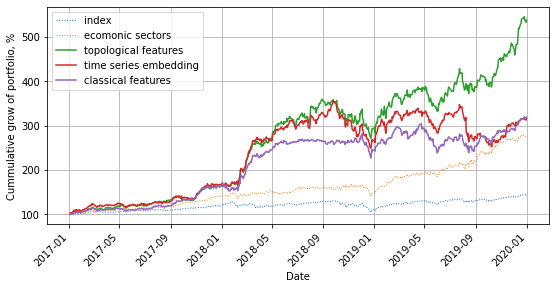

In [188]:
plt.figure(figsize=(9, 4))

for method_name, vals in methods.items():
    plt.plot((1+ vals).cumprod() * 100, label=method_name, **method_styles[method_name])

plt.xticks(rotation=45, ha='right')
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cummulative grow of portfolio, %')

plt.show()